In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import cv2

from datetime import datetime


from lyft_dataset_sdk.lyftdataset import LyftDataset
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [6]:
level5data = LyftDataset(data_path='./', json_path='./v1.01-train/', verbose=True)

9 category,
18 attribute,
4 visibility,
18421 instance,
10 sensor,
148 calibrated_sensor,
177789 ego_pose,
180 log,
180 scene,
22680 sample,
189504 sample_data,
638179 sample_annotation,
1 map,
Done loading in 18.0 seconds.
Reverse indexing ...
Done reverse indexing in 3.4 seconds.


In [12]:
records = [(level5data.get('sample', record['first_sample_token'])['timestamp'], record) for record in level5data.scene]
entries = []

In [16]:
for start_time, record in sorted(records):
    start_time = level5data.get('sample', record['first_sample_token'])['timestamp'] / 1000000
    token = record['token']
    name = record['name']
    date = datetime.utcfromtimestamp(start_time)
    host = "-".join(record['name'].split("-")[:2])
    first_sample_token = record["first_sample_token"]

    entries.append((host, name, date, token, first_sample_token))

In [18]:
df = pd.DataFrame(entries, columns=["host", "scene_name", "date", "scene_token", "first_sample_token"])

In [20]:
host_count_df = df.groupby("host")['scene_token'].count()
print(host_count_df)

host
host-a004    42
host-a005     1
host-a006     3
host-a007    26
host-a008     5
host-a009     9
host-a011    51
host-a012     2
host-a015     6
host-a017     3
host-a101    20
host-a102    12
Name: scene_token, dtype: int64


In [30]:
validation_hosts = ["host-a007", "host-a008", "host-a009"]

validation_df = df[df["host"].isin(validation_hosts)]
vi = validation_df.index
train_df = df[~df.index.isin(vi)]

In [28]:
classes = ["car", "motorcycle", "bus", "bicycle", "truck", "pedestrian", "other_vehicle", "animal", "emergency_vehicle"]

In [35]:
sample_token = train_df.first_sample_token.values[0]
sample = level5data.get("sample", sample_token)

{'CAM_BACK_RIGHT': 'cc8b48b5bc7ac966c637a75c1ca9753e0aad73b4085061500eb33c7cdd552fb3',
 'CAM_FRONT_ZOOMED': 'ca9fe0b7b4b05add26b95a07cb15b0cee93b93bf5d77cb325da0cb2ecf2e6dc5',
 'LIDAR_TOP': '5d6d78ab8d58702d82284d89c164311b79dbf131be93f477f0cb2fcfe673ba74',
 'CAM_FRONT_RIGHT': '631f2a014d5b44ee322590d75d1da3487375aafeab947f654bffecbda88c44b0',
 'CAM_BACK_LEFT': 'bc34c5c7e83561df1ad1884d8c63a992ea67b51440754aeb0198ca39a8d6d1d8',
 'CAM_FRONT': 'b95d2f63a539fc4d5f356101dbca3ba516dba6a662140fc17ee54fddf176e80f',
 'CAM_BACK': '247b8de08fac995483f3aa89403feee4ee2138a1b5331ac4968754bc2fe53245',
 'CAM_FRONT_LEFT': '3fee299ccf90916993d1285d42ecce298b2148daa8b571a90ca9d2c7fc589198'}

In [36]:
sample_lidar_token = sample["data"]["LIDAR_TOP"]
lidar_data = level5data.get("sample_data", sample_lidar_token)
lidar_filepath = level5data.get_sample_data_path(sample_lidar_token)

In [39]:
ego_pose = level5data.get("ego_pose", lidar_data["ego_pose_token"])
calibrated_sensor = level5data.get("calibrated_sensor", lidar_data["calibrated_sensor_token"])

In [44]:
global_from_car = transform_matrix(ego_pose['translation'],Quaternion(ego_pose['rotation']), inverse=False)
car_from_sensor = transform_matrix(calibrated_sensor['translation'], Quaternion(calibrated_sensor['rotation']),inverse=False)

In [46]:
lidar_pointcloud = LidarPointCloud.from_file(lidar_filepath)

# The lidar pointcloud is defined in the sensor's reference frame.
# We want it in the car's reference frame, so we transform each point
lidar_pointcloud.transform(car_from_sensor)
map_mask = level5data.map[0]["mask"]

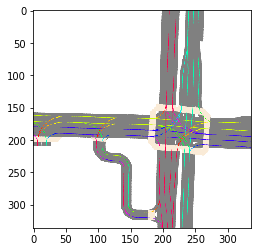

In [52]:
def get_semantic_map_around_ego(map_mask, ego_pose, voxel_size, output_shape):

    def crop_image(image: np.array, x_px: int, y_px: int, axes_limit_px: int) -> np.array:
        x_min = int(x_px - axes_limit_px)
        x_max = int(x_px + axes_limit_px)
        y_min = int(y_px - axes_limit_px)
        y_max = int(y_px + axes_limit_px)

        cropped_image = image[y_min:y_max, x_min:x_max]

        return cropped_image

    pixel_coords = map_mask.to_pixel_coords(ego_pose['translation'][0], ego_pose['translation'][1])

    extent = voxel_size*output_shape[0]*0.5
    scaled_limit_px = int(extent * (1.0 / (map_mask.resolution)))
    mask_raster = map_mask.mask()

    cropped = crop_image(mask_raster, pixel_coords[0], pixel_coords[1], int(scaled_limit_px * np.sqrt(2)))

    ypr_rad = Quaternion(ego_pose['rotation']).yaw_pitch_roll
    yaw_deg = -np.degrees(ypr_rad[0])

    rotated_cropped = np.array(Image.fromarray(cropped).rotate(yaw_deg))
    ego_centric_map = crop_image(rotated_cropped, rotated_cropped.shape[1] / 2, rotated_cropped.shape[0] / 2,
                                 scaled_limit_px)[::-1]
    
    ego_centric_map = cv2.resize(ego_centric_map, output_shape[:2], cv2.INTER_NEAREST)
    return ego_centric_map.astype(np.float32)/255
    
ego_centric_map = get_semantic_map_around_ego(map_mask, ego_pose, voxel_size=0.4, output_shape=(336,336)) 
plt.imshow(ego_centric_map)
plt.show()